## PGE 383 Graduate Student Project

## Demonstration of an Overfitting Random Forest Model
#### Dinghan Wang
#### Department of Petroleum and Geosystems Engineering
### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

### Executive Summary

* What is the gap, problem, opportunity, scientific question?

* What was done to address the above?

* What was learned?

* What are your recommendations?

### This project explores the  demonstration of an overfitting Random Forest regression model, addressing the gap in understanding how even ensemble methods like RF typically robust against overfitting due to averaging across multiple trees—can still overfit under certain conditions. To investigate this, a Random Forest model was intentionally configured with minimal regularization. The results showed that the model fit the training data almost perfectly but performed poorly on unseen data, confirming that overfitting is possible when RF hyperparameters are improperly tuned. The highlights the importance of careful parameter selection and validation techniques, and it is recommended that practitioners monitor out-of-bag error or use cross-validation to ensure generalizability, even with models considered resistant to overfitting

### Workflow

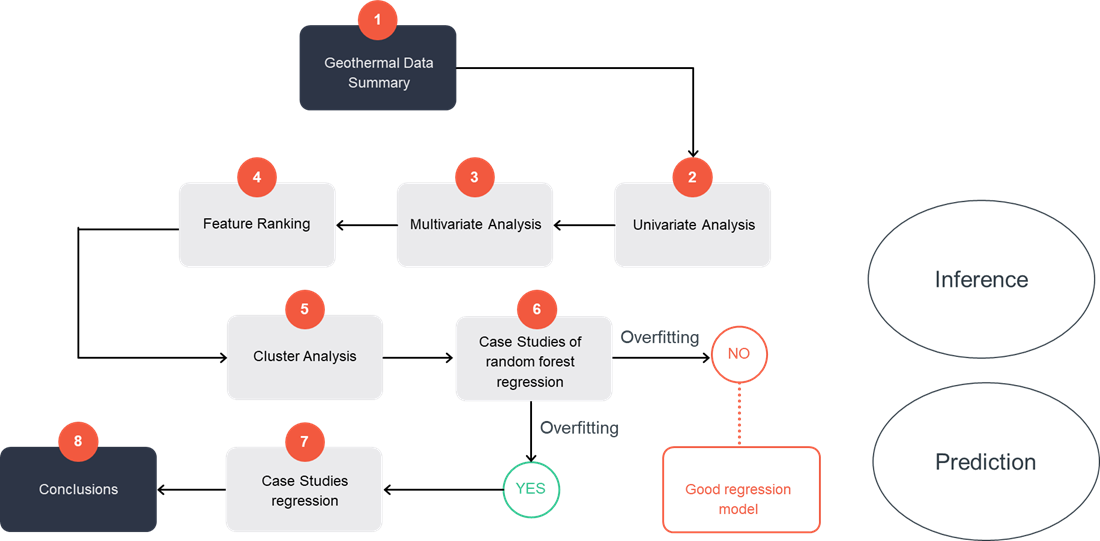

### Data summary and source

#### The dataset that I used is from open source Github, there are 15 columns originally, but considering the physical meaning and missing data, only five columns have been chosen to represent five features, the first four are predictor features which are latitude, longitude, grad (geothermal thermal gradient) in the unit (°C/km), k(thermal conductivity) in the unit (W/mK), the last column is the response feature GHF (geothermal heat flow) in the unit Milliwatts-per-square-meter (mW/m²) 

### Background of the data (why geothermal matters)

#### Combining latitude, longitude, grad, and k allows you to:Map regions with optimal GHF for energy projects (e.g., Iceland, Kenya, or the U.S. West Coast). Avoid areas with low GHF or challenging geology, reducing exploration risks. Cost Efficiency High grad and k values correlate with lower drilling costs and faster energy payback. Thermal conductivity data prevents overestimating energy output in low-conductivity zones. Climate and Engineering Insights GHF maps inform ice sheet stability models (e.g., Thwaites Glacier’s high GHF accelerates melting). Industrial applications (e.g., cement production) rely on GHF data to replace fossil fuels with geothermal heat. Overall, this analysis bridges geology, energy economics, and climate science, making it essential for advancing sustainable energy solutions.


### Import Packages

In [1]:
%matplotlib inline                                         
suppress_warnings = True
import os                                                     # to set current working directory 
import math                                                   # square root operator
import numpy as np                                            # arrays and matrix math
import scipy.stats as st                                      # statistical methods
import pandas as pd                                           # DataFrames
import pandas.plotting as pd_plot
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python  
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import seaborn as sns                                         # for matrix scatter plots
from sklearn import metrics                                   # measures to check our models
from sklearn.preprocessing import StandardScaler              # standardize the features
from sklearn import metrics                                   # measures to check our models
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,KFold) # model tuning
from IPython.display import display, HTML                     # custom displays
from scipy import stats                                       # Rank correlation
import numpy.linalg as linalg                                 # for linear algebra
cmap = plt.cm.inferno                                         # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                                # grid behind plotting elements
if suppress_warnings == True:  
    import warnings                                           # suppress any warnings for this demonstration
    warnings.filterwarnings('ignore') 
seed = 13

### Functions

In [24]:
# The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).

In [2]:
def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal)
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,m-1.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,m-1.5]); add_grid();
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.cm.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar(im, orientation = 'vertical')
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])

def partial_corr(C):                                          # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr


def mutual_matrix(df,features):                               # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                        # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):                   # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):                    # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

### Load Data

In [3]:
url = "https://github.com/RicardaDziadek/Antarctic-GHF-DB/raw/master/ANT_GHF_DB_V004.xlsx"
df = pd.read_excel(url)

In [4]:
df

,(1) Latitude,(2) Longitude,(3) Station ID,(4) top (m),(5) bot (m),(6) grad (°C/km),(7) k(W/mK),(8) GHF (mW/m²),(9) Err (mW/m²),(10) Elevation (m.a.s.l.),(11) Reference,(12) DOI,(13) DataQuality,(14) Method,(15) Comment,Unnamed: 15,Unnamed: 16
0,-56.5667,34.1833,C11-44,0.0,11,300,0.77,229.0,NaN,-5372.0,Anderson1977,https://doi.org/10.1594/PANGAEA.796541,S3,Unconsolidated sediments,NaN,NaN,NaN
1,-56.3000,51.9667,C11-45,0.0,11,19,0.72,14.0,NaN,-5386.0,Anderson1977,https://doi.org/10.1594/PANGAEA.796541,S3,Unconsolidated sediments,NaN,NaN,NaN
2,-52.7000,54.0000,C11-47,0.0,11,90,0.72,65.0,NaN,-4585.0,Anderson1977,https://doi.org/10.1594/PANGAEA.796541,S3,Unconsolidated sediments,NaN,NaN,NaN
3,-50.4667,59.5833,C11-48,0.0,7,360,0.75,271.0,NaN,-4839.0,Anderson1977,https://doi.org/10.1594/PANGAEA.796541,S3,Unconsolidated sediments,NaN,NaN,NaN
4,-50.3167,61.2000,C11-49,0.0,11,120,0.68,81.0,NaN,-4640.0,Anderson1977,https://doi.org/10.1594/PANGAEA.796541,S3,Unconsolidated sediments,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,-61.1000,-19.8500,IO15-49,NaN,10,,0.81,84.0,,-4764.0,Zlotnicki1980,https://doi.org/10.1029/GL007i006p00421,S2,Unconsolidated sediments,bot (m) from depths in https://doi.org/10.1029...,NaN,NaN
444,-66.2500,-33.0667,IO15-52,NaN,11,,0.86,64.0,,-4933.0,Zlotnicki1980,https://doi.org/10.1029/GL007i006p00421,S2,Unconsolidated sediments,bot (m) from depths in https://doi.org/10.1029...,NaN,NaN
445,-64.0667,-36.9500,IO15-55,NaN,6,,1.25,175.0,,-4797.0,Zlotnicki1980,https://doi.org/10.1029/GL007i006p00421,S2,Unconsolidated sediments,bot (m) from depths in https://doi.org/10.1029...,NaN,NaN
446,-63.1000,-38.4500,IO15-56,NaN,8,,1.03,105.0,,-4495.0,Zlotnicki1980,https://doi.org/10.1029/GL007i006p00421,S2,Unconsolidated sediments,bot (m) from depths in https://doi.org/10.1029...,NaN,NaN


### Data Preprocesssing 

#### Remove some useless columns

In [5]:
cols_to_drop = [2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16]
df = df.drop(df.columns[cols_to_drop], axis=1)

# Display the resulting DataFrame
print(df.head())

   (1) Latitude  (2) Longitude (6) grad (°C/km) (7) k(W/mK)  (8) GHF (mW/m²)
0      -56.5667        34.1833              300        0.77            229.0
1      -56.3000        51.9667               19        0.72             14.0
2      -52.7000        54.0000               90        0.72             65.0
3      -50.4667        59.5833              360        0.75            271.0
4      -50.3167        61.2000              120        0.68             81.0


#### Handle missing data

In [6]:
df = df.dropna()
df

,(1) Latitude,(2) Longitude,(6) grad (°C/km),(7) k(W/mK),(8) GHF (mW/m²)
0,-56.5667,34.1833,300,0.77,229.0
1,-56.3000,51.9667,19,0.72,14.0
2,-52.7000,54.0000,90,0.72,65.0
3,-50.4667,59.5833,360,0.75,271.0
4,-50.3167,61.2000,120,0.68,81.0
...,...,...,...,...,...
443,-61.1000,-19.8500,,0.81,84.0
444,-66.2500,-33.0667,,0.86,64.0
445,-64.0667,-36.9500,,1.25,175.0
446,-63.1000,-38.4500,,1.03,105.0


#### Rename column names

In [7]:
df = df.rename(columns={"(1) Latitude": "Latitude"})
df = df.rename(columns={"(2) Longitude": "Longitude"})
df = df.rename(columns={"(6) grad (°C/km)": "grad (°C/km)"})
df = df.rename(columns={"(7) k(W/mK)": "k(W/mK)"})
df = df.rename(columns={"(8) GHF (mW/m²)": "GHF (mW/m²)"})
df

,Latitude,Longitude,grad (°C/km),k(W/mK),GHF (mW/m²)
0,-56.5667,34.1833,300,0.77,229.0
1,-56.3000,51.9667,19,0.72,14.0
2,-52.7000,54.0000,90,0.72,65.0
3,-50.4667,59.5833,360,0.75,271.0
4,-50.3167,61.2000,120,0.68,81.0
...,...,...,...,...,...
443,-61.1000,-19.8500,,0.81,84.0
444,-66.2500,-33.0667,,0.86,64.0
445,-64.0667,-36.9500,,1.25,175.0
446,-63.1000,-38.4500,,1.03,105.0


### Univariate Analysis of the Response feature (we can see how single feature is distributed)

#### PDF plot

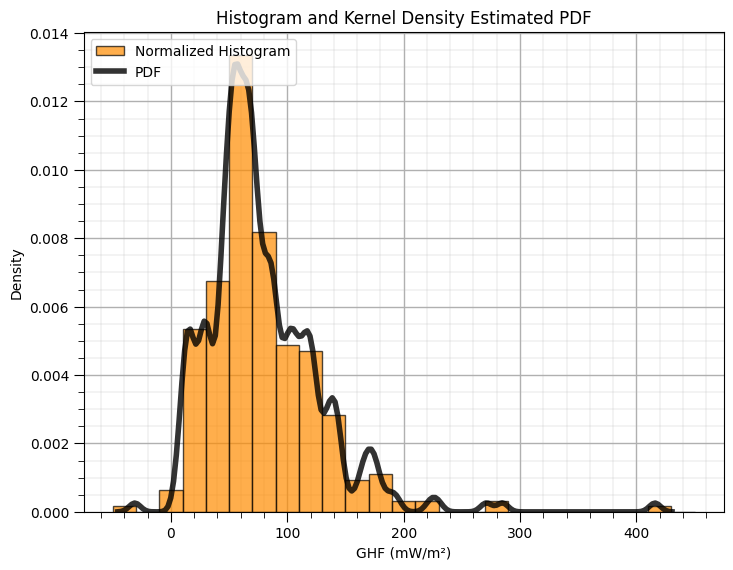

In [8]:
plt.hist(df['GHF (mW/m²)'].values,alpha=0.7,color="darkorange",edgecolor="black",bins=25,range=[-50,450],density=True,
         label = 'Normalized Histogram')
sns.kdeplot(x=df['GHF (mW/m²)'].values,color = 'black',alpha = 0.8,linewidth=4.0,bw_method=0.10,label = 'PDF')
plt.title('Histogram and Kernel Density Estimated PDF'); plt.xlabel('GHF (mW/m²)'); plt.ylabel("Density")
plt.legend(loc='upper left'); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.1, hspace=0.2); plt.show()

#### CDF plot

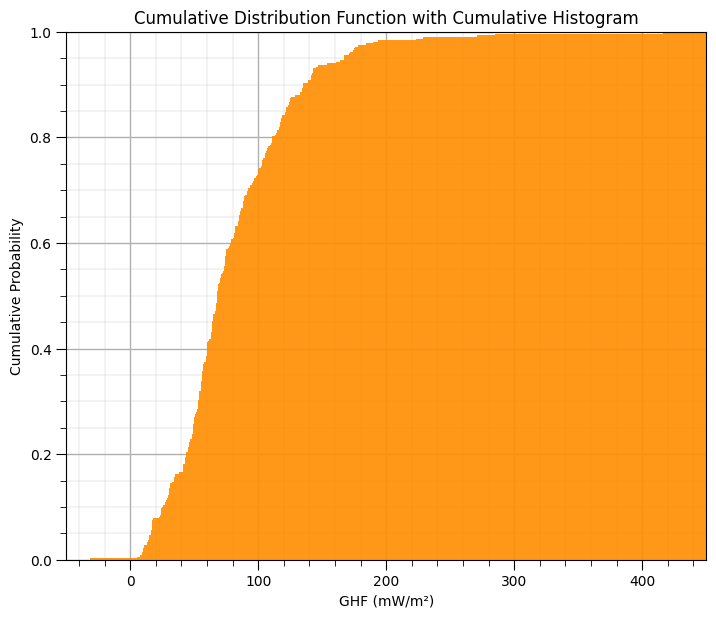

In [9]:
GSLIB.hist_st(df['GHF (mW/m²)'].values,-50,450,log=False,cumul = True,bins=1000,weights = None, # CDF with GeostatsPy
           xlabel='GHF (mW/m²)',title='Cumulative Distribution Function with Cumulative Histogram'); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

In [10]:
#change data type for further analysis
# Convert relevant columns to numeric, forcing non-numeric entries to NaN
cols_to_clean = ['Latitude', 'Longitude', 'grad (°C/km)','k(W/mK)', 'GHF (mW/m²)']
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' turns errors into NaN

# Drop rows with any NaNs in those columns
df = df.dropna(subset=cols_to_clean)

### Bivariate Analysis (we can see the distribution between two variables)

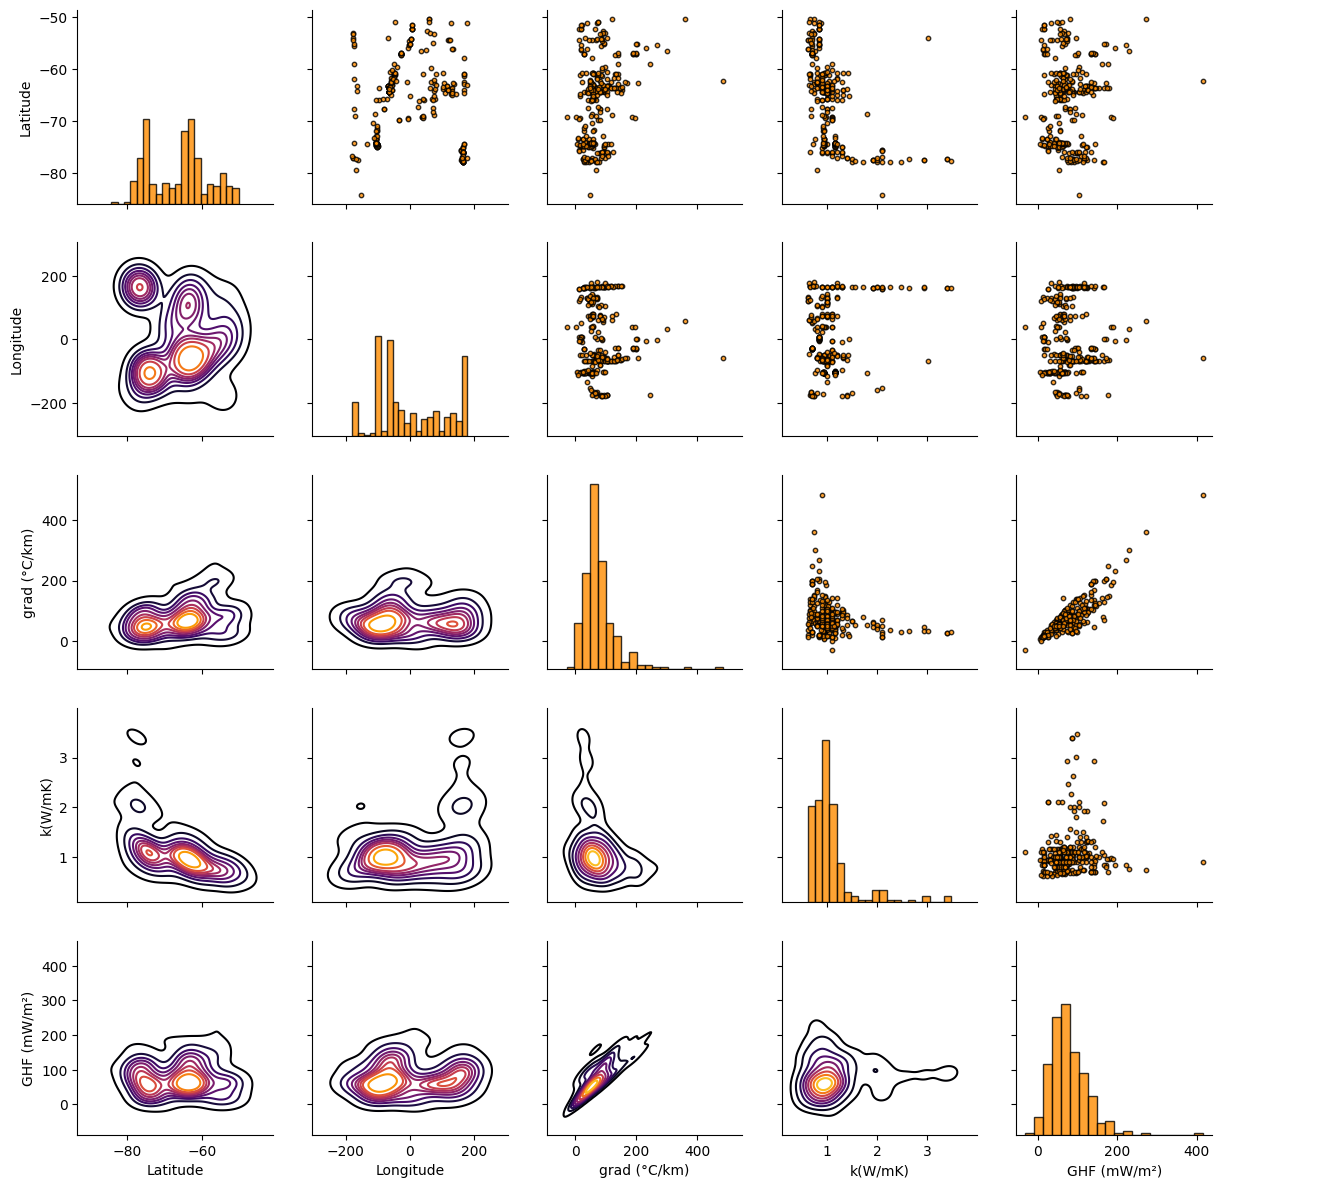

In [11]:
pairgrid = sns.PairGrid(df,vars=['Latitude',	'Longitude','grad (°C/km)',	'k(W/mK)',	'GHF (mW/m²)']) # matrix scatter plots
pairgrid = pairgrid.map_upper(plt.scatter, color = 'darkorange', edgecolor = 'black', alpha = 0.8, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'darkorange',alpha = 0.8, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, shade_lowest = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2); plt.show()

#### Response and predictor feature split

In [12]:
response = 'GHF (mW/m²)'
x = df.copy(deep = True); x = x.drop(['GHF (mW/m²)',response],axis='columns') # make predictor and response DataFrames
Y = df.loc[:,response]

features = x.columns.values.tolist() + [Y.name]               # store the names of the features
pred = x.columns.values.tolist()
resp = Y.name

In [13]:
m = len(pred) + 1
mpred = len(pred)

#### Covariance Matrix

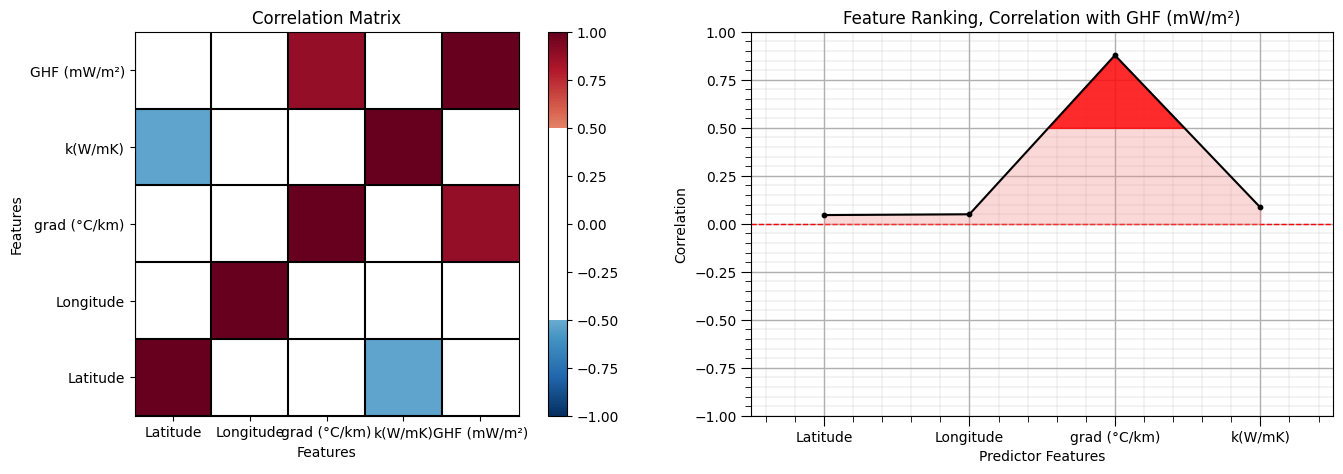

In [14]:
correlation = df.corr().iloc[4,:4]              # calculate correlation matrix and slice for only pred - resp
corr_matrix = df.corr()

plt.subplot(121)
plot_corr(corr_matrix,'Correlation Matrix',1.0,0.5)           # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

#### Rank Correlation Matrix


Rank Correlation p-value:

[5.71399330e-01 3.03464795e-02 1.51961007e-67 5.32589571e-03]


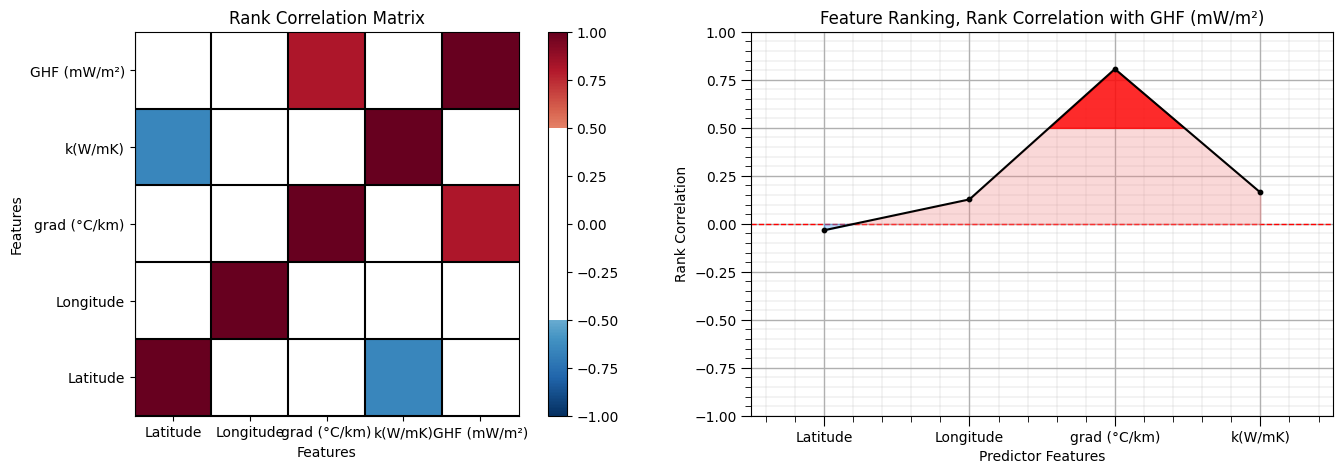

In [15]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df) # calculate the range correlation coefficient
rank_matrix = pd.DataFrame(rank_correlation,columns=corr_matrix.columns)
rank_correlation = rank_correlation[:,4][:4]
rank_correlation_pval = rank_correlation_pval[:,4][:4]
print("\nRank Correlation p-value:\n"); print(rank_correlation_pval)

plt.subplot(121)
plot_corr(rank_matrix,'Rank Correlation Matrix',1.0,0.5)      # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

#### Partial Correlation Matrix

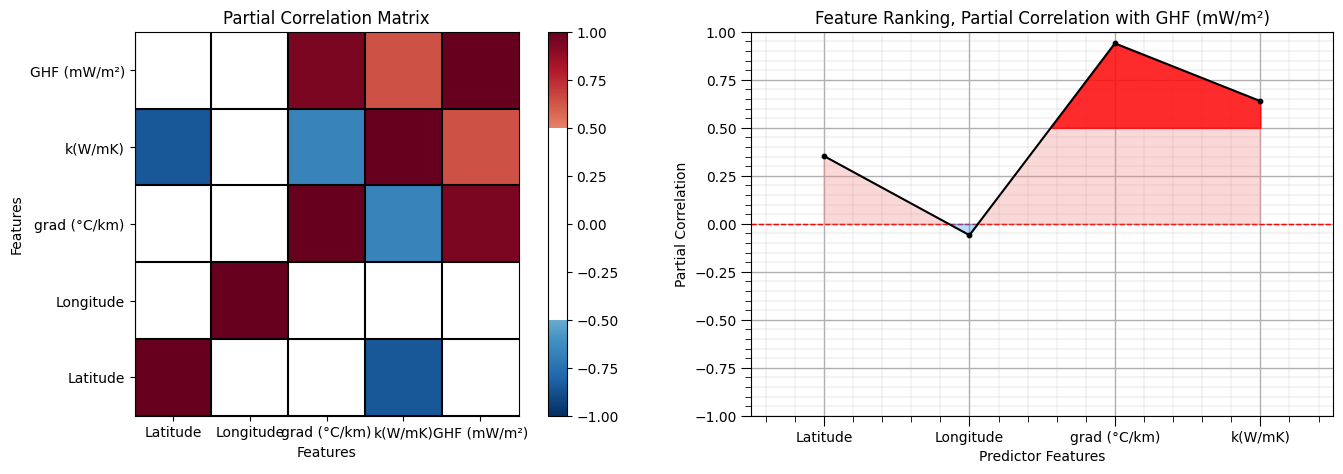

In [16]:
partial_correlation = partial_corr(df)            # calculate the partial correlation coefficients
partial_matrix = pd.DataFrame(partial_correlation,columns=corr_matrix.columns)
partial_correlation = partial_correlation[:,4][:4]            # extract a single row and remove production with itself

plt.subplot(121)
plot_corr(partial_matrix,'Partial Correlation Matrix',1.0,0.5) # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

### Summary of our dataset: We can plot any variable that we are insterested in by using PDF and CDF plot. Our response feature is mainly smaller than 100. By comparing rank correlation and covariance correlation, we have no outliers in dataset, when we look at partial correlation, we can twll grad and K are two most important features with GHF

#### VIF shows the redundency between predictor features, latitude is a bit redundent but all others will be fine to use

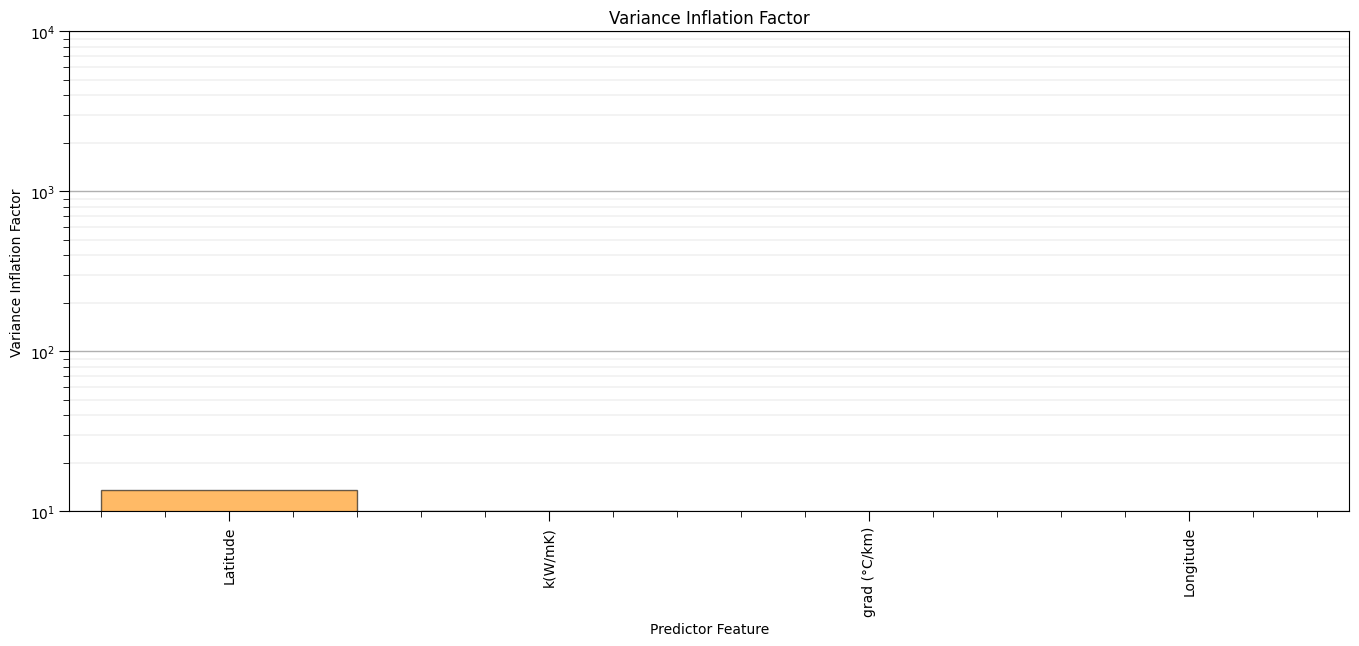

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_values = []
for i in range(x.shape[1]):
    vif_values.append(variance_inflation_factor(x.values, i))

vif_values = np.asarray(vif_values)
indices = np.argsort(vif_values)[::-1]                  # find indices for descending order

plt.subplot(111)                                        # plot the feature importance 
plt.title("Variance Inflation Factor")
plt.bar(range(x.shape[1]), vif_values[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6, align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90); 

plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

plt.xlim([-0.5, x.shape[1]-0.5]); plt.yscale('log'); plt.ylim([1.0e1,1.0e4])
plt.xlabel('Predictor Feature'); plt.ylabel('Variance Inflation Factor')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

#### MI method to show feature importance, gradient is the most important feature

Feature ranking:
1. feature grad (°C/km) = 1.000000
2. feature Longitude = 0.324008
3. feature Latitude = 0.267691
4. feature k(W/mK) = 0.197156


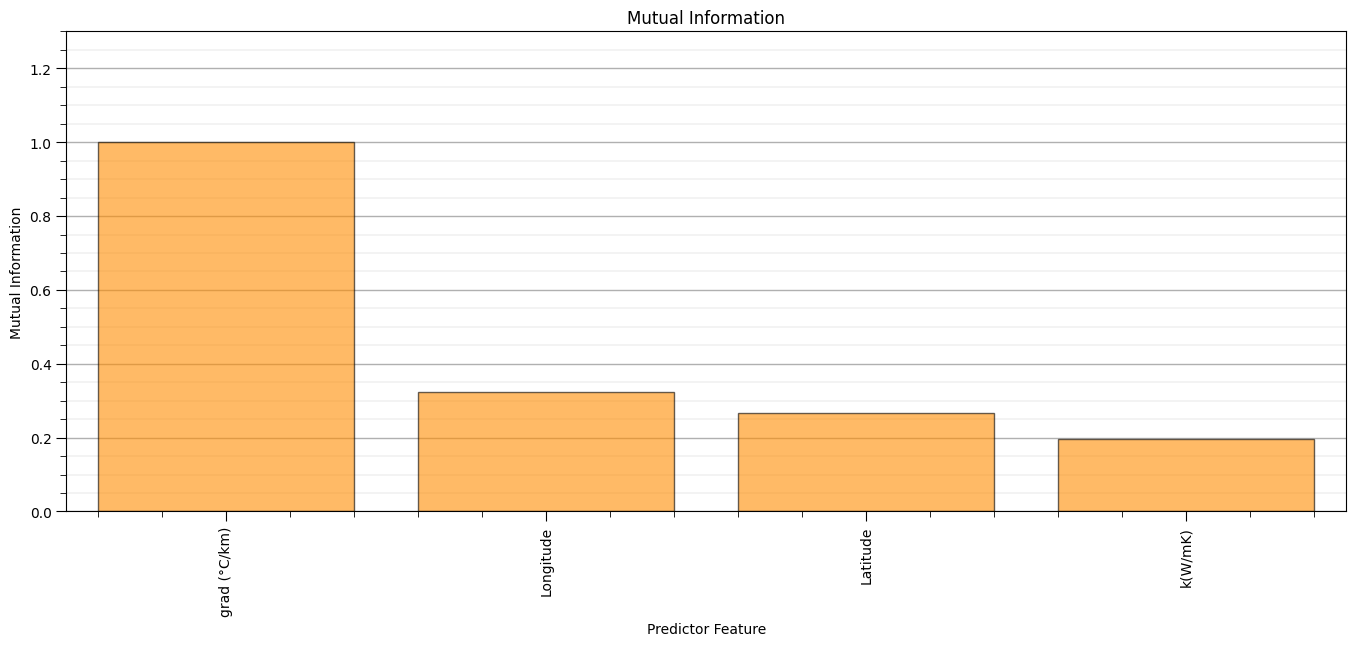

In [18]:
from sklearn.feature_selection import mutual_info_regression 

x = df.iloc[:,[0,1,2,3]]                            # separate DataFrames for predictor and response features
y = df.iloc[:,[4]]

mi = mutual_info_regression(x,np.ravel(y))              # calculate mutual information
mi /= np.max(mi)                                        # calculate relative mutual information

indices = np.argsort(mi)[::-1]                          # find indices for descending order

print("Feature ranking:")                               # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                                        # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1.3])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Predictor Feature'); plt.ylabel('Mutual Information')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

### Summary: No feaature redundency here and we can just put all four features into models, MI scores match the bivariate analysis above.

### Random forest regressor with Hyperparameter tuning and train test data split

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Standardize predictors
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.iloc[:, [0,1,2,3]])
y = df.iloc[:, [4]].values.ravel()  # Flatten y

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(x_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Params: {grid_search.best_params_}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Test MSE: 250.139
Test R²: 0.866


#### Train and test R2 score during grid search to convey the info that it s an overfitting model

Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test MSE: 240.374
Test R²: 0.868

Top 10 parameter combinations by test R²:
    mean_train_score  mean_test_score  std_train_score  std_test_score  \
27          0.980032         0.872132         0.002762        0.089142   
64          0.942144         0.871422         0.014976        0.093345   
10          0.942144         0.871422         0.014976        0.093345   
28          0.977950         0.870782         0.004548        0.089772   
37          0.942375         0.870287         0.014644        0.094747   
29          0.977665         0.869689         0.004743        0.091036   
2           0.977812         0.869449         0.004796        0.090217   
56          0.977812         0.869449         0.004796        0.090217   
4           0.963428         0.869342         0.005627        0.083077   
58          0.963428         0.869342         0.005627        0.083077   

           

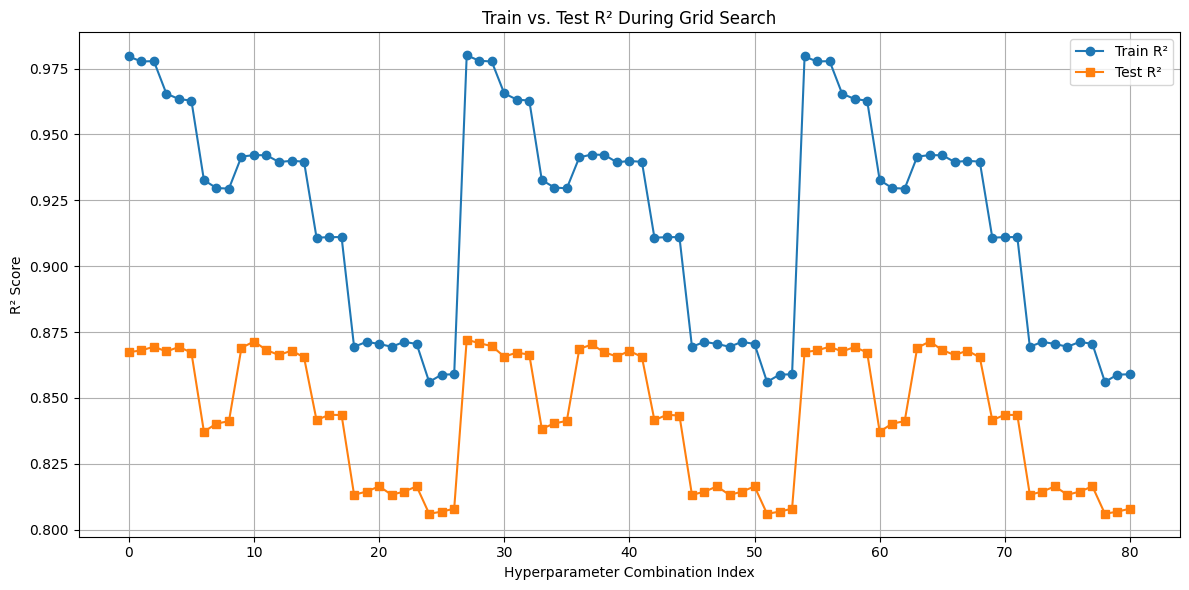

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Standardize predictors
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.iloc[:, [0, 1, 2, 3]])
y = df.iloc[:, [4]].values.ravel()

# 2. Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.3, random_state=42
)

# 3. Random Forest model
rf = RandomForestRegressor(random_state=42)

# 4. Hyperparameter tuning grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 5. Grid SearchCV with train score tracking
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='r2', n_jobs=-1, return_train_score=True
)
grid_search.fit(x_train, y_train)

# 6. Best model & predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test)

# 7. Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Params: {grid_search.best_params_}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

# 8. Get results dataframe
results = pd.DataFrame(grid_search.cv_results_)
results_summary = results[[
    'mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score', 'params'
]].sort_values(by='mean_test_score', ascending=False)

print("\nTop 10 parameter combinations by test R²:")
print(results_summary.head(10))

# 9. Plot train vs. test R²
plt.figure(figsize=(12, 6))
plt.plot(results['mean_train_score'], label='Train R²', marker='o')
plt.plot(results['mean_test_score'], label='Test R²', marker='s')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('R² Score')
plt.title('Train vs. Test R² During Grid Search')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### The visulization of the training and testing results (We see training data is along the 45 degree line and testing data is sparese)

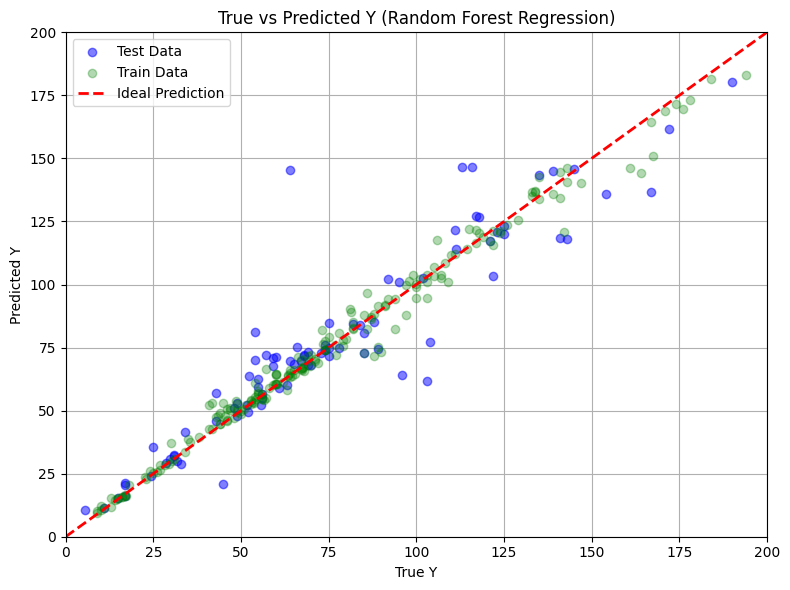

In [21]:
import matplotlib.pyplot as plt

# Predict on training data
y_train_pred = best_rf.predict(x_train)

# Plot
plt.figure(figsize=(8, 6))

# Test data (blue)
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Test Data')

# Train data (green)
plt.scatter(y_train, y_train_pred, color='green', alpha=0.3, label='Train Data')

# 45-degree reference line
plt.plot([0, 200], [0, 200], color='red', linestyle='--', lw=2, label='Ideal Prediction')

# Axis limits
plt.xlim(0, 200)
plt.ylim(0, 200)

# Labels and legend
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('True vs Predicted Y (Random Forest Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Traing MSE vs. Testing MSE (We see a huge gap between train and test results which convey that it s an overfitting model)

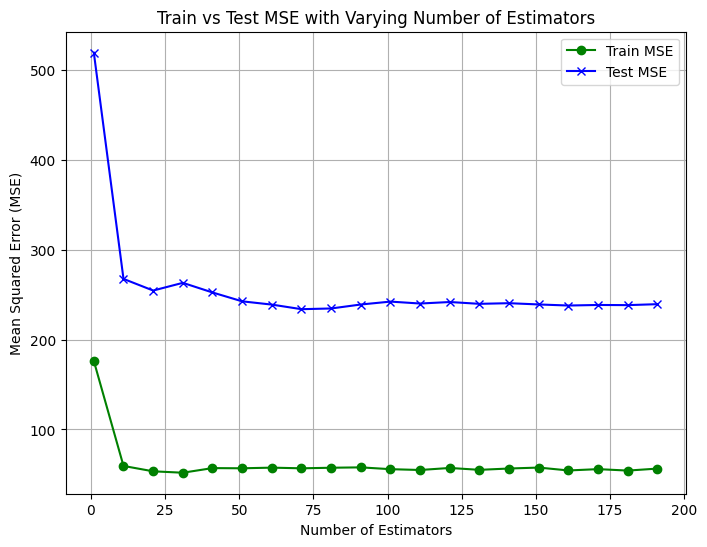

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Set a range of number of estimators
n_estimators_range = np.arange(1, 201, 10)  # From 1 to 200 with a step of 10
train_mse = []
test_mse = []

# Loop through different values of n_estimators
for n_estimators in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                               max_depth=None, 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               random_state=42)
    
    # Train the model
    rf.fit(x_train, y_train)
    
    # Make predictions
    y_train_pred = rf.predict(x_train)
    y_test_pred = rf.predict(x_test)
    
    # Calculate MSE for training and test data
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

# Plot the MSE vs number of estimators
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_range, train_mse, label='Train MSE', color='green', marker='o')
plt.plot(n_estimators_range, test_mse, label='Test MSE', color='blue', marker='x')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Train vs Test MSE with Varying Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

#### plot other hyperparameters vs. train and test error to show that we haven't tuned those poorly resulting in systemattic high test error

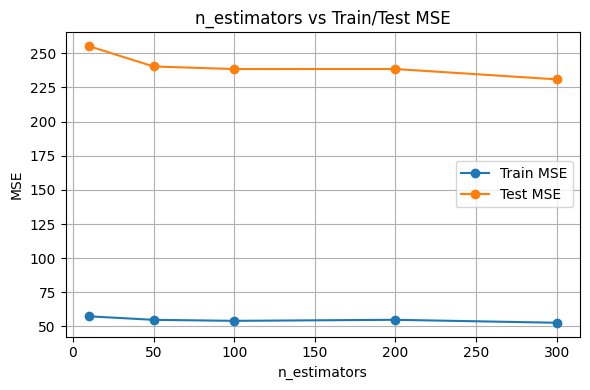

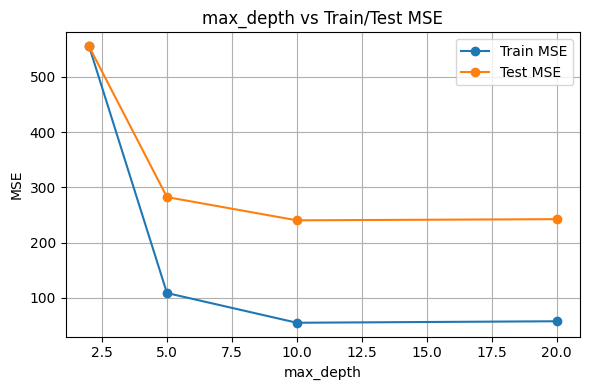

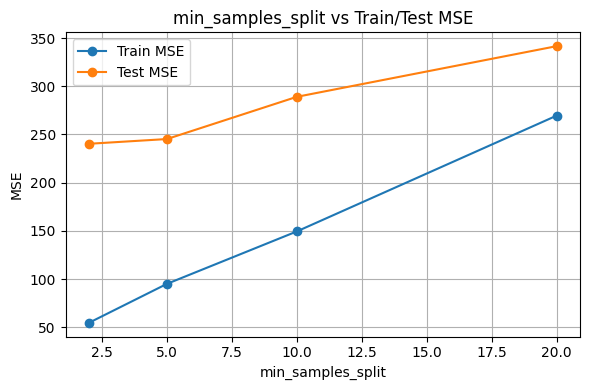

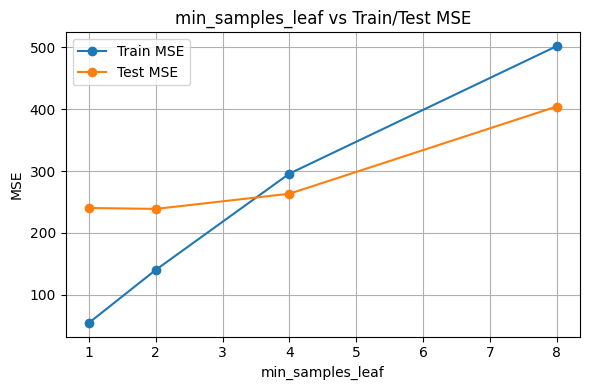

In [23]:
import matplotlib.pyplot as plt

# Function to evaluate train/test error for different hyperparameter values
def plot_hyperparam_effect(param_name, param_values, fixed_params):
    train_errors = []
    test_errors = []

    for val in param_values:
        # Set current hyperparameter value and keep others fixed
        params = fixed_params.copy()
        params[param_name] = val

        model = RandomForestRegressor(**params, random_state=42)
        model.fit(x_train, y_train)

        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        train_errors.append(train_mse)
        test_errors.append(test_mse)

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(param_values, train_errors, label='Train MSE', marker='o')
    plt.plot(param_values, test_errors, label='Test MSE', marker='o')
    plt.xlabel(param_name)
    plt.ylabel('MSE')
    plt.title(f'{param_name} vs Train/Test MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Use best params as a baseline, except the one we vary
best_params = grid_search.best_params_

# Plot effects for each hyperparameter (adjust ranges if needed)
plot_hyperparam_effect('n_estimators', [10, 50, 100, 200, 300], {k: v for k, v in best_params.items() if k != 'n_estimators'})
plot_hyperparam_effect('max_depth', [2, 5, 10, 20, None], {k: v for k, v in best_params.items() if k != 'max_depth'})
plot_hyperparam_effect('min_samples_split', [2, 5, 10, 20], {k: v for k, v in best_params.items() if k != 'min_samples_split'})
plot_hyperparam_effect('min_samples_leaf', [1, 2, 4, 8], {k: v for k, v in best_params.items() if k != 'min_samples_leaf'})

### Summary: We successfully built an overfit random forest regressor with Best Params. When we look at the true y vs. predicted y for training and testing data, the training data are bascially all along the diagnol but testing data are skewed somewhere which proves the overfit of the model, the trainging is perfect and model complexity is high, but testing is not that good. Then we can also refer to train and test MSE and R2 plots with different combination of hyperparameters, we also notice a gap between training and testing which also tells the overfitting issue. Overall. this project explores the demonstration of an overfitting Random Forest regression model, addressing the gap in understanding how even ensemble methods like RF typically robust against overfitting due to averaging across multiple trees—can still overfit under certain conditions. To investigate this, a Random Forest model was intentionally configured with minimal regularization. The results showed that the model fit the training data almost perfectly but performed poorly on unseen data, confirming that overfitting is possible when RF hyperparameters are improperly tuned. The highlights the importance of careful parameter selection and validation techniques, and it is recommended that practitioners monitor out-of-bag error or use cross-validation to ensure generalizability, even with models considered resistant to overfitting. 

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)